<a href="https://colab.research.google.com/github/pemujo/w210-capstone/blob/main/Model_2_U_Net_Focal_Loss_5_Contrails_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Models Based on UNet
### Contrails Dataset (Image Segmentation)

    Team: Pedro Melendez | Ziling Huang | Sitao Chen | Rebecca Nissan | Prakash Krishnan <br>

    Term: w210-Summer 2023 <br>

# Introduction

This notebook has baseline prototype image segmentation models built on UNET architecture. For proof of concept only 1,000 images are considered and are split into train and test splits.

Three models are considered here:

    Experiment 1: Single Time Step Image Extracted from the False Color Image (aka Ash Image) as Feature and Human Mask Label as the Label.

    Experiment 2: Blended False Color Image of 8 Time Steps using Mean as Feature and Human Mask Label as the Label.

    Experiment 3: Weighted False Color Image of 8 Time Steps using individual time step weighting as Feature and Human Mask Label as the Label.

Dataset Summary:

The dataset for this notebook is Google Research - Identify Contrails to Reduce Global Warming hosted by Kaggle.

    https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data

The original satellite images were obtained from the GOES-16 Advanced Baseline Imager (ABI), which is publicly available on Google Cloud Storage. The original full-disk images were reprojected using bilinear resampling to generate a local scene image. Because contrails are easier to identify with temporal context, a sequence of images at 10-minute intervals are provided. Each example (record_id) contains exactly one labeled frame.

Learn more about the dataset from the preprint: OpenContrails: Benchmarking Contrail Detection on GOES-16 ABI. Labeling instructions can be found at in this supplementary material. Some key labeling guidance:

    Contrails must contain at least 10 pixels
    At some time in their life, Contrails must be at least 3x longer than they are wide
    Contrails must either appear suddenly or enter from the sides of the image
    Contrails should be visible in at least two image

Ground truth was determined by (generally) 4+ different labelers annotating each image. Pixels were considered a contrail when >50% of the labelers annotated it as such. Individual annotations (human_individual_masks.npy) as well as the aggregated ground truth annotations (human_pixel_masks.npy) are included in the training data. The validation data only includes the aggregated ground truth annotations.

Files

    train/ - the training set; each folder represents a record_id and contains the following data:
        band_{08-16}.npy: array with size of H x W x T, where T = n_times_before + n_times_after + 1, representing the number of images in the sequence. There are n_times_before and n_times_after images before and after the labeled frame respectively. In our dataset all examples have n_times_before=4 and n_times_after=3. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found here.
        human_individual_masks.npy: array with size of H x W x 1 x R. Each example is labeled by R individual human labelers. R is not the same for all samples. The labeled masks have value either 0 or 1 and correspond to the (n_times_before+1)-th image in band_{08-16}.npy. They are available only in the training set.
        human_pixel_masks.npy: array with size of H x W x 1 containing the binary ground truth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers.

Evaluation Metrics

    Total Loss is determined as an effective loss function as the minority class (presence of contrails) is small compared to the background.

    dice_loss = sm.losses.DiceLoss(class_weights = weights)
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (TOTAL_LOSS_FACTOR * focal_loss)

Hyper Parameters

    TOTAL_LOSS_FACTOR
    NUM_EPOCHS
    BATCH_SIZE

# Import Libraries

In [1]:
!pip install gcsfs -q
!pip install pandarallel -q

import pandas as pd
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
# from IPython import print
import os
import glob
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import platform

print(platform.system())
print(platform.release())
# 18.2.0

print(platform.version())
print(platform.platform())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.6 MB/s eta 0:00:00
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Linux
5.15.107+
#1 SMP Sat Apr 29 09:15:28 UTC 2023
Linux-5.15.107+-x86_64-with-glibc2.31


# Check for Colab

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


# Authenticate User

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gcsfs
fs = gcsfs.GCSFileSystem(project='multi-tenancy-dataproc')

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


# Read Data From GCP Bucket for a Particular Record ID

In [ ]:
BASE_DIR = 'kaggle-contrails/contrails-kaggle-files/train/'
N_TIMES_BEFORE = 4
# record_id = '1704010292581573769'
record_id = '8070893861055857193'
with fs.open(BASE_DIR + record_id + '/band_11.npy', 'rb') as f:
    band11 = np.load(f)
with fs.open(BASE_DIR + record_id + '/band_14.npy', 'rb') as f:
    band14 = np.load(f)
with fs.open(BASE_DIR + record_id + '/band_15.npy', 'rb') as f:
    band15 = np.load(f)
with fs.open(BASE_DIR + record_id + '/human_pixel_masks.npy', 'rb') as f:
    human_pixel_mask = np.load(f)
with fs.open(BASE_DIR + record_id + '/human_individual_masks.npy', 'rb') as f:
    human_individual_mask = np.load(f)

# inspect files
print("band_11 shape", (band11.shape))
print("human pixel mask shape: ",(human_pixel_mask.shape))
print("unique values in human pixel mask", np.unique(human_pixel_mask))
print("human individual mask shape", human_individual_mask.shape)

# create false color image from the bands
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

# inspect false color shape
print("false color shape", false_color.shape)



band_11 shape (256, 256, 8)
human pixel mask shape:  (256, 256, 1)
unique values in human pixel mask [0 1]
human individual mask shape (256, 256, 1, 4)
false color shape (256, 256, 3, 8)


# Visualize False Color Image

image shape (256, 256, 3)


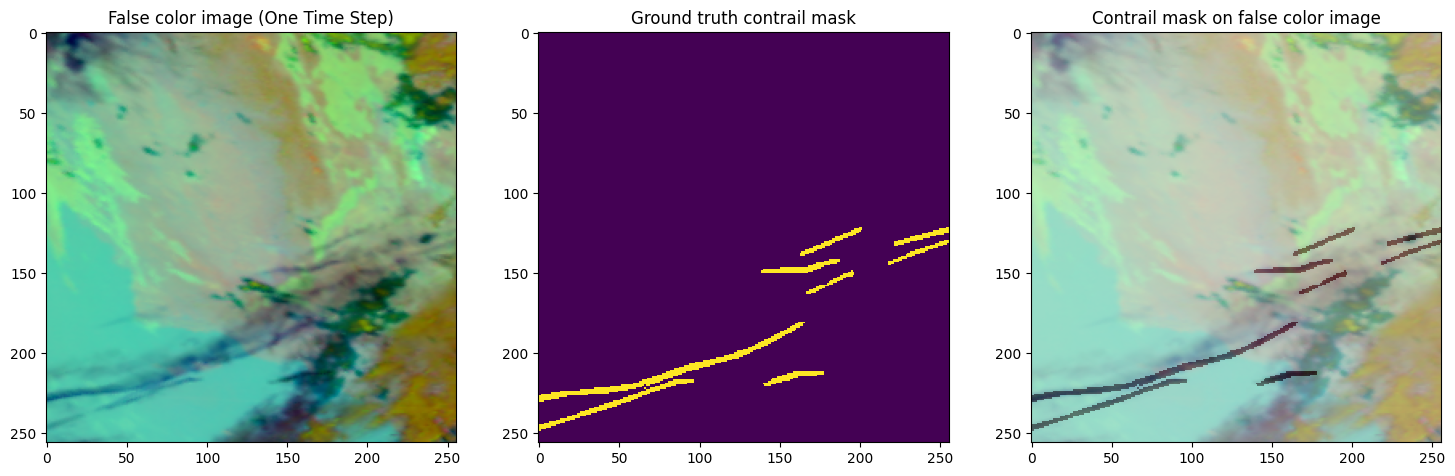

In [ ]:
N_TIMES_BEFORE = 4

img = false_color[..., N_TIMES_BEFORE] # Note this picks one time step for visualization

# NOTE: false_color[..., N_TIMES_BEFORE] is the same as false_color[:,:,:,N_TIMES_BEFORE]

print("image shape", img.shape)

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image (One Time Step)')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

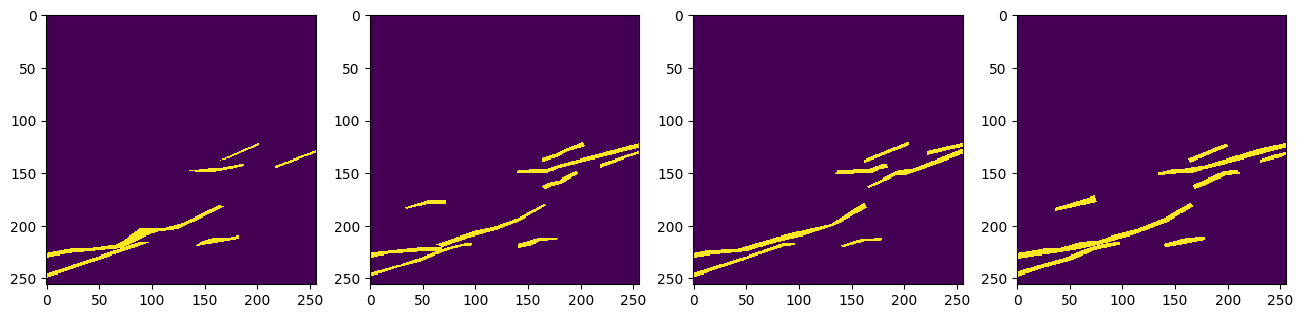

In [ ]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none')

image shape (256, 256, 3)
img mean weights shape (256, 256, 3)
img time step weighted (256, 256, 3)


Text(0.5, 1.0, 'False color image (weighted time steps)')

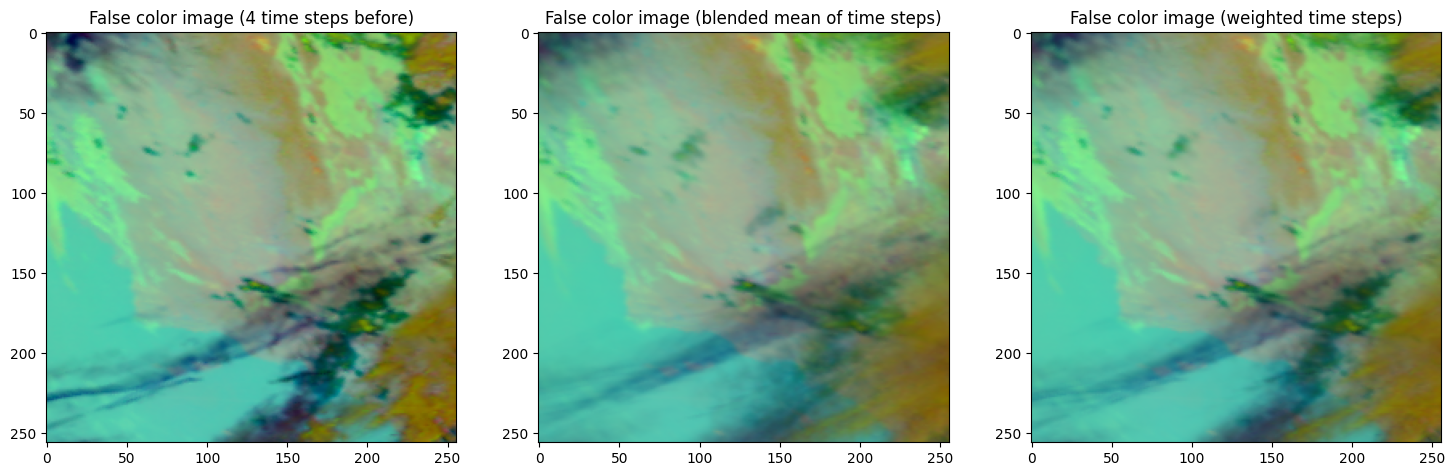

In [ ]:
# In this section instead of one time step for original image, we use a blended mean of 8 time steps and weighted time steps

N_TIMES_BEFORE = 4
img = false_color[..., N_TIMES_BEFORE] # Note this picks one time step for visualization
# NOTE: false_color[..., N_TIMES_BEFORE] is the same as false_color[:,:,:,N_TIMES_BEFORE]

print("image shape", img.shape)

img_mean = np.mean(false_color, axis=3)
print("img mean weights shape", img_mean.shape)

img_weighted = 0.03 * false_color[:,:,:,0] + 0.03 * false_color[:,:,:,1] + 0.05 * false_color[:,:,:,2] + 0.20 * false_color[:,:,:,3] + 0.40 * false_color[:,:,:,4] + 0.20 * false_color[:,:,:,5] + 0.05 * false_color[:,:,:,6] + 0.04 * false_color[:,:,:,7]
print("img time step weighted", img_weighted.shape)

# N_TIMES_BEFORE = 4
# img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 3, 2)
ax.imshow(img_mean)
ax.set_title('False color image (blended mean of time steps)')

ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image (4 time steps before)')

ax = plt.subplot(1, 3, 3)
ax.imshow(img_weighted)
ax.set_title('False color image (weighted time steps)')


# Read Meta Data File

In [ ]:
train_metadata_df = pd.read_json("gs://kaggle-contrails/contrails-kaggle-files/train_metadata.json")

# inspect data frame
print(train_metadata_df)

contrails_df = pd.DataFrame(fs.ls(BASE_DIR), columns = ['record_id_path'])
print(contrails_df)

        record_id_metadata                                     projection_wkt  \
0      3283699311323360256  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
1      8563667897034605568  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
2      6375533009500587008  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
3      3029407526724838912  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
4      4486503791474809856  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
...                    ...                                                ...   
20524  2784921205987946496  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20525  9072953982653736960  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20526  2998013562139868160  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20527  8070893861055857664  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   
20528  1609423943725151232  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1...   

           row_min     row_

# Prepare Dataset for Models

In [ ]:
NUMBER_OF_RECORDS = 1000 # User Enterable

In [ ]:
# Build Dataset
record_id_list = (train_metadata_df['record_id'].to_list())
print(len(record_id_list))

# Note 1000 is user enterable
record_id_list = record_id_list[0:NUMBER_OF_RECORDS]
print(len(record_id_list))

20529
1000


In [ ]:
# # Method 1 - Read Files from GCP Bucket

# false_color_image_list = []
# false_color_blended_image_list = []
# ground_truth_contrail_mask_list = []

# for idx, id in enumerate(record_id_list):

#   print("idx: ", idx )
#   BASE_DIR = 'kaggle-contrails/contrails-kaggle-files/train/'
#   N_TIMES_BEFORE = 4
#   record_id = str(id)
#   # record_id = '8070893861055857193'
#   with fs.open(BASE_DIR + record_id + '/band_11.npy', 'rb') as f:
#       band11 = np.load(f)

#   # with fs.open(BASE_DIR + record_id + '/ash_image.npy', 'rb') as f:
#   #     false_color = np.load(f)


#   with fs.open(BASE_DIR + record_id + '/band_14.npy', 'rb') as f:
#       band14 = np.load(f)
#   with fs.open(BASE_DIR + record_id + '/band_15.npy', 'rb') as f:
#       band15 = np.load(f)
#   with fs.open(BASE_DIR + record_id + '/human_pixel_masks.npy', 'rb') as f:
#       human_pixel_mask = np.load(f)
#   with fs.open(BASE_DIR + record_id + '/human_individual_masks.npy', 'rb') as f:
#       human_individual_mask = np.load(f)

#   _T11_BOUNDS = (243, 303)
#   _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
#   _TDIFF_BOUNDS = (-4, 2)

#   def normalize_range(data, bounds):
#       """Maps data to the range [0, 1]."""
#       return (data - bounds[0]) / (bounds[1] - bounds[0])

#   r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
#   g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
#   b = normalize_range(band14, _T11_BOUNDS)
#   false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
#   # false_color = ash

#   img = false_color[..., N_TIMES_BEFORE] # do need
#   img_mean = np.mean(false_color, axis=3)

#   false_color_image_list.append(img)
#   false_color_blended_image_list.append(img_mean)
#   ground_truth_contrail_mask_list.append(human_pixel_mask)

# # Inspect the datasets
# image_dataset = np.asarray(false_color_image_list)
# image_blended_dataset = np.asarray(false_color_blended_image_list)
# mask_dataset = np.asarray(ground_truth_contrail_mask_list)
# labels = mask_dataset

# print(image_dataset.shape)
# print(image_blended_dataset.shape)
# print(mask_dataset.shape)
# print(np.unique(mask_dataset))

# # Sanity Check Random Images and Labels

# random_image_id = 88

# plt.figure(figsize=(18,6))

# ax = plt.subplot(1, 3, 1)
# ax.imshow(image_dataset[random_image_id])
# ax.set_title('False Color Image: ' + str(random_image_id))

# ax = plt.subplot(1, 3, 2)
# ax.imshow(image_blended_dataset[random_image_id])
# ax.set_title('Blended Image: ' + str(random_image_id))

# ax = plt.subplot(1, 3, 3)
# ax.imshow(mask_dataset[random_image_id])
# ax.set_title('Mask Image: ' + str(random_image_id))



idx:  0
idx:  1
idx:  2
idx:  3
idx:  4
idx:  5
idx:  6
idx:  7
idx:  8
idx:  9
idx:  10
idx:  11
idx:  12
idx:  13
idx:  14
idx:  15
idx:  16
idx:  17
idx:  18
idx:  19
idx:  20
idx:  21
idx:  22
idx:  23
idx:  24
idx:  25
idx:  26
idx:  27
idx:  28
idx:  29
idx:  30
idx:  31
idx:  32
idx:  33
idx:  34
idx:  35
idx:  36
idx:  37
idx:  38
idx:  39
idx:  40
idx:  41
idx:  42
idx:  43
idx:  44
idx:  45
idx:  46
idx:  47
idx:  48
idx:  49
idx:  50
idx:  51
idx:  52
idx:  53
idx:  54
idx:  55
idx:  56
idx:  57
idx:  58
idx:  59
idx:  60
idx:  61
idx:  62
idx:  63
idx:  64
idx:  65
idx:  66
idx:  67
idx:  68
idx:  69
idx:  70
idx:  71
idx:  72
idx:  73
idx:  74
idx:  75
idx:  76
idx:  77
idx:  78
idx:  79
idx:  80
idx:  81
idx:  82
idx:  83
idx:  84
idx:  85
idx:  86
idx:  87
idx:  88
idx:  89
idx:  90
idx:  91
idx:  92
idx:  93
idx:  94
idx:  95
idx:  96
idx:  97
idx:  98
idx:  99
idx:  100
idx:  101
idx:  102
idx:  103
idx:  104
idx:  105
idx:  106
idx:  107
idx:  108
idx:  109
idx:  110


Text(0.5, 1.0, 'Mask Image: 88')

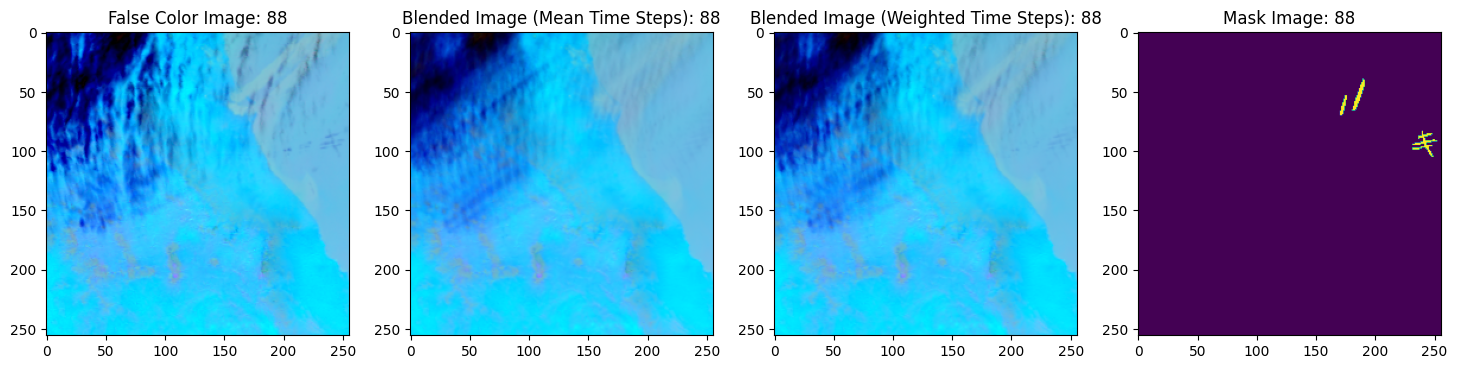

In [ ]:
# Method 2 - Read Ash Files from GCP Bucket. Pedro has created ash images with 8 time steps in google storage bucket.

false_color_image_list = [] # single time steps
false_color_blended_image_list = [] # equal weights
false_color_weighted_image_list = [] # non uniform weights
ground_truth_contrail_mask_list = [] # ground truth mask

for idx, id in enumerate(record_id_list):

  print("idx: ", idx )
  BASE_DIR = 'kaggle-contrails/contrails-kaggle-files/train/'
  N_TIMES_BEFORE = 4
  record_id = str(id)

  with fs.open(BASE_DIR + record_id + '/ash_image.npy', 'rb') as f:
      false_color = np.load(f)

  with fs.open(BASE_DIR + record_id + '/human_pixel_masks.npy', 'rb') as f:
      human_pixel_mask = np.load(f)

  # generate 3 types of false color images

  img = false_color[..., N_TIMES_BEFORE] # single time step
  img_mean = np.mean(false_color, axis=3) # mean of 8 time steps

  # img weighted is individually weighted by time steps. Time steps 4,5,6 account for 80% of weighting
  img_weighted = 0.03 * false_color[:,:,:,0] + 0.03 * false_color[:,:,:,1] + 0.05 * false_color[:,:,:,2] + 0.20 * false_color[:,:,:,3] + 0.40 * false_color[:,:,:,4] + 0.20 * false_color[:,:,:,5] + 0.05 * false_color[:,:,:,6] + 0.04 * false_color[:,:,:,7]

  # append images to list
  false_color_image_list.append(img)
  false_color_blended_image_list.append(img_mean)
  false_color_weighted_image_list.append(img_weighted)
  ground_truth_contrail_mask_list.append(human_pixel_mask)

# Inspect the datasets
image_dataset = np.asarray(false_color_image_list)
image_blended_dataset = np.asarray(false_color_blended_image_list)
image_weighted_dataset = np.asarray(false_color_weighted_image_list)
mask_dataset = np.asarray(ground_truth_contrail_mask_list)
labels = mask_dataset

print("image dataset shape", image_dataset.shape)
print("image blended dataset with equual wts shape: ", image_blended_dataset.shape)
print("image dataset time step weighted shape: ", image_weighted_dataset.shape)
print("mask dataset shape:", mask_dataset.shape)
print("mask unique values", np.unique(mask_dataset))

# Sanity Check Random Images and Labels

random_image_id = 88

plt.figure(figsize=(18,6))

ax = plt.subplot(1, 4, 1)
ax.imshow(image_dataset[random_image_id])
ax.set_title('False Color Image: ' + str(random_image_id))

ax = plt.subplot(1, 4, 2)
ax.imshow(image_blended_dataset[random_image_id])
ax.set_title('Blended Image (Mean Time Steps): ' + str(random_image_id))

ax = plt.subplot(1, 4, 3)
ax.imshow(image_weighted_dataset[random_image_id])
ax.set_title('Blended Image (Weighted Time Steps): ' + str(random_image_id))

ax = plt.subplot(1, 4, 4)
ax.imshow(mask_dataset[random_image_id])
ax.set_title('Mask Image: ' + str(random_image_id))


# Build UNET Model

In [ ]:
# install necessary libraries

!pip install patchify -q
!pip install -U segmentation-models -q

import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

minmaxscaler = MinMaxScaler()

# Converts categorical integers to one hot encoding 0 and 1
from tensorflow.keras.utils import to_categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.3 MB/s eta 0:00:00


### Define Classes

In [ ]:
total_classes = len(np.unique(labels))
print("number of classes: ",total_classes)

number of classes:  2


### Convert Integer 0 1 Labels to One Hot Encoding

In [ ]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

# inspect labels_categorical_dataset
print("labels shape before one hot encoding: ", labels.shape)
print("labels shape after one hot encoding: ", labels_categorical_dataset.shape)

labels shape before one hot encoding:  (1000, 256, 256, 1)
labels shape after one hot encoding:  (1000, 256, 256, 2)


### Sanity Check and Visual Inspection

Text(0.5, 1.0, 'Labels (0 and 1): 122')

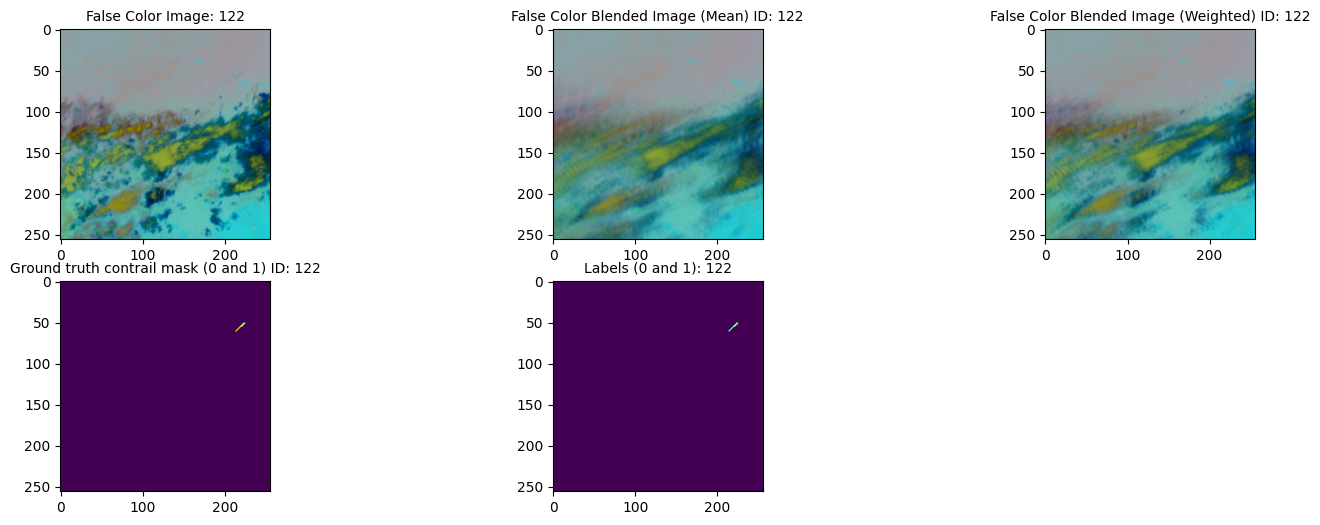

In [ ]:
import random
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(18,6))

ax = plt.subplot(2, 3, 1)
ax.imshow(image_dataset[random_image_id])
ax.set_title('False Color Image: '+str(random_image_id), fontsize=10)

ax = plt.subplot(2, 3, 2)
ax.imshow(image_blended_dataset[random_image_id])
ax.set_title('False Color Blended Image (Mean) ID: '+str(random_image_id), fontsize=10)

ax = plt.subplot(2, 3, 3)
ax.imshow(image_weighted_dataset[random_image_id])
ax.set_title('False Color Blended Image (Weighted) ID: '+str(random_image_id), fontsize=10)

ax = plt.subplot(2, 3, 4)
ax.imshow(mask_dataset[random_image_id])
ax.set_title('Ground truth contrail mask (0 and 1) ID: '+str(random_image_id), fontsize=10)

ax = plt.subplot(2, 3, 5)
ax.imshow(labels[random_image_id])
ax.set_title('Labels (0 and 1): '+str(random_image_id), fontsize=10)

# Experiment 1: Single Time Image as Feature. Used Time Step 5 as the Feature.


In [ ]:
# Hyper Parameters

NUM_EPOCHS = 100
BATCH_SIZE = 32
TOTAL_LOSS_FACTOR = 5

In [ ]:
# Training dataset
master_training_dataset = image_dataset
print("training dataset shape: ", master_training_dataset.shape)

from sklearn.model_selection import train_test_split

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.20, random_state=100) # change later to 0.20

# inspect shapes of train and test
print("X Train Shape: ", X_train.shape)
print("X Test Shape: ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

training dataset shape:  (1000, 256, 256, 3)
X Train Shape:  (800, 256, 256, 3)
X Test Shape:  (200, 256, 256, 3)
y train shape:  (800, 256, 256, 2)
y test shape:  (200, 256, 256, 2)


In [ ]:
# U NET Model Parameters

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

total_classes = len(np.unique(labels))

print("image ht: ", image_height)
print("image width: ", image_width)
print("image channels: ", image_channels)
print("total classes: ", total_classes)

image ht:  256
image width:  256
image channels:  3
total classes:  2


In [ ]:
# Import necessary keras libraries for UNET
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

from keras import backend as K
# backend is tensor flow. At tensor level calculation, Keras does not cover it. Keras is only the framework. All backend methods are referred as K

#import segmentation_models as sm
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import tensorflow as tf

tf.keras.backend.clear_session()

!pip install focal_loss -q

Segmentation Models: using `tf.keras` framework.


In [ ]:
# custom metric for model

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
# Create a U NET Model
# Note default values are specified in the function.

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels)) # Here 256, 256, 3

  source_input = inputs

# First Block in U-Net Architecture
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

# Second Block in U-Net Architecture (increase filters to 32 from 16)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

# Third Block in U-Net Architecture (increase filters to 64 from 32)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

# 4th Block in U-Net Architecture (increase filters to 128 from 64)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

# 5th Block in U-Net Architecture (increase filters to 256 from 128)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
# define the model function

def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
# call function and store in model object
model = get_deep_learning_model()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [ ]:
# weights for 2 classes
weights = [0.5,0.5] # hyper parameter

In [ ]:
# from segmentation model use dice and focal loss
# TOTAL_LOSS_FACTOR is a hyper parameter

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (TOTAL_LOSS_FACTOR * focal_loss)

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
#model.compile(optimizer="adam", loss=BinaryFocalLoss(gamma=10), metrics=metrics)

In [ ]:
# inspect model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Fit the Model

history_1 = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
25/25 [==============================] - 35s 428ms/step - loss: 0.8552 - accuracy: 0.8184 - jaccard_coef: 0.7146 - val_loss: 0.7778 - val_accuracy: 0.9944 - val_jaccard_coef: 0.7233
Epoch 2/100
25/25 [==============================] - 9s 359ms/step - loss: 0.7666 - accuracy: 0.9944 - jaccard_coef: 0.9032 - val_loss: 0.7689 - val_accuracy: 0.9944 - val_jaccard_coef: 0.8075
Epoch 3/100
25/25 [==============================] - 9s 363ms/step - loss: 0.7642 - accuracy: 0.9945 - jaccard_coef: 0.9122 - val_loss: 0.7696 - val_accuracy: 0.9944 - val_jaccard_coef: 0.7952
Epoch 4/100
25/25 [==============================] - 9s 366ms/step - loss: 0.7633 - accuracy: 0.9945 - jaccard_coef: 0.9202 - val_loss: 0.7687 - val_accuracy: 0.9944 - val_jaccard_coef: 0.8035
Epoch 5/100
25/25 [==============================] - 9s 370ms/step - loss: 0.7627 - accuracy: 0.9945 - jaccard_coef: 0.9231 - val_loss: 0.7676 - val_accuracy: 0.9944 - val_jaccard_coef: 0.8129
Epoch 6/100
25/25 [===============

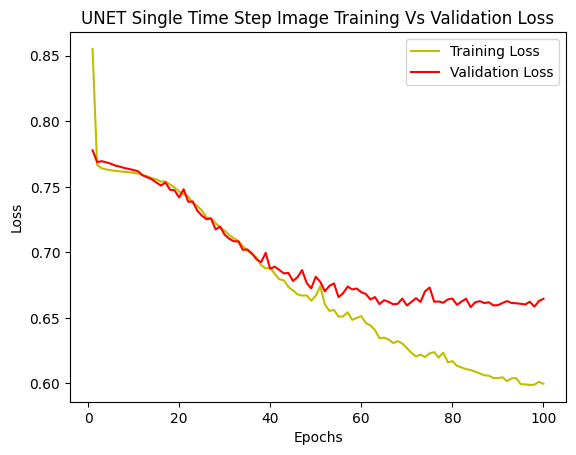

In [ ]:
# Visualize Results

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("UNET Single Time Step Image Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

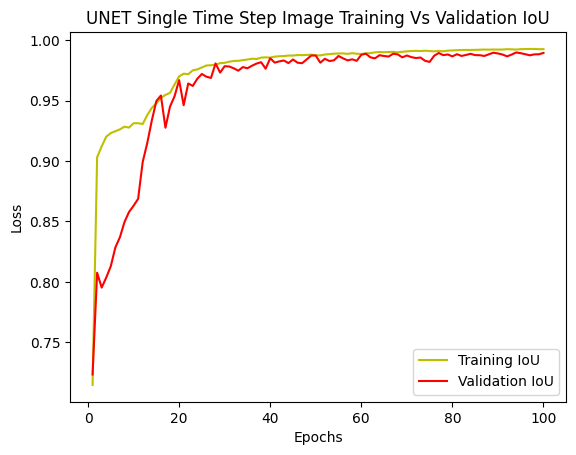

In [ ]:
jaccard_coef = history_1.history['jaccard_coef']
val_jaccard_coef = history_1.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("UNET Single Time Step Image Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Comparing Visual Predictions with Ground Truth


In [ ]:
# Predict on a test image
import random
# test_img_number = random.randint(0, len(X_test)-1)
test_img_number = 143
print(test_img_number)

#####################################################################

143


In [ ]:
# Get Predictions

y_pred = model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

display(y_pred.shape, y_test.shape, y_pred_argmax.shape, y_test_argmax.shape)
print("")

test_img_1 = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
predicted_img_1 = y_pred_argmax[test_img_number]

display(test_img_1.shape, ground_truth.shape, predicted_img_1.shape)
print("")

7/7 [==============================] - 1s 67ms/step


(200, 256, 256, 2)

(200, 256, 256, 2)

(200, 256, 256)

(200, 256, 256)

(256, 256, 3)

(256, 256)

(256, 256)

In [ ]:
# Get Mean IOU for Experiment
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
mean_iou_1 = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou_1)

Mean IoU = 0.63868916


Text(0.5, 1.0, 'Ground Truth ID: 143')

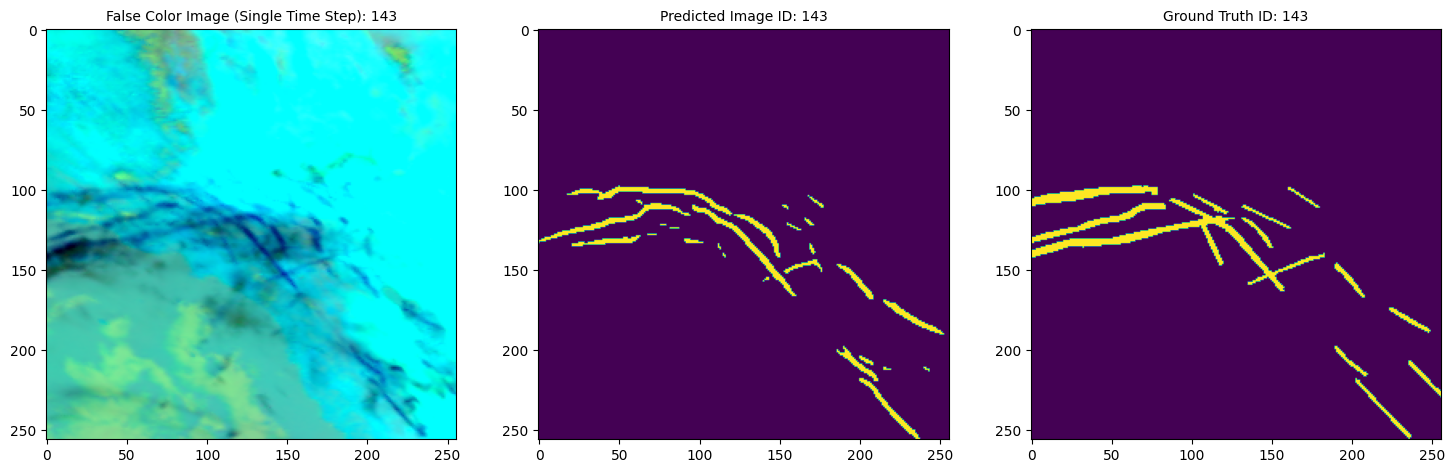

In [ ]:
# Visualize Predictions

plt.figure(figsize=(18,6))

ax = plt.subplot(1, 3, 1)
ax.imshow(test_img_1)
ax.set_title('False Color Image (Single Time Step): '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 2)
ax.imshow(predicted_img_1)
ax.set_title('Predicted Image ID: '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 3)
ax.imshow(ground_truth)
ax.set_title('Ground Truth ID: '+str(test_img_number), fontsize=10)

# Save Model To Disk

In [ ]:
filepath = 'drive/My Drive/Data_SCI_W210_Capstone/Contrails/Model_Saved/model_2_focal_loss_5_unblended.h5'
model.save(filepath)

In [ ]:
from keras.models import load_model

In [ ]:
weights = [0.5,0.5] # hyper parameter
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (10 * focal_loss)

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
loaded_model = load_model(filepath,custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef})

In [ ]:
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# Experiment 2: Blended Mean Image as Feature. Used Average of 8 Time Steps

In [ ]:
# Training dataset
master_training_dataset = image_blended_dataset
print("training dataset shape: ", master_training_dataset.shape)

from sklearn.model_selection import train_test_split

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.20, random_state=100) # change later to 0.20

# inspect shapes of train and test
print("X Train Shape: ", X_train.shape)
print("X Test Shape: ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

training dataset shape:  (1000, 256, 256, 3)
X Train Shape:  (800, 256, 256, 3)
X Test Shape:  (200, 256, 256, 3)
y train shape:  (800, 256, 256, 2)
y test shape:  (200, 256, 256, 2)


In [ ]:
history_2 = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
25/25 [==============================] - 10s 396ms/step - loss: 0.7642 - accuracy: 0.9941 - jaccard_coef: 0.9509 - val_loss: 0.7549 - val_accuracy: 0.9933 - val_jaccard_coef: 0.9697
Epoch 2/100
25/25 [==============================] - 10s 382ms/step - loss: 0.7526 - accuracy: 0.9928 - jaccard_coef: 0.9723 - val_loss: 0.7482 - val_accuracy: 0.9915 - val_jaccard_coef: 0.9769
Epoch 3/100
25/25 [==============================] - 10s 385ms/step - loss: 0.7481 - accuracy: 0.9912 - jaccard_coef: 0.9753 - val_loss: 0.7505 - val_accuracy: 0.9931 - val_jaccard_coef: 0.9827
Epoch 4/100
25/25 [==============================] - 10s 384ms/step - loss: 0.7488 - accuracy: 0.9910 - jaccard_coef: 0.9735 - val_loss: 0.7471 - val_accuracy: 0.9883 - val_jaccard_coef: 0.9714
Epoch 5/100
25/25 [==============================] - 10s 383ms/step - loss: 0.7478 - accuracy: 0.9916 - jaccard_coef: 0.9764 - val_loss: 0.7529 - val_accuracy: 0.9865 - val_jaccard_coef: 0.9722
Epoch 6/100
25/25 [===========

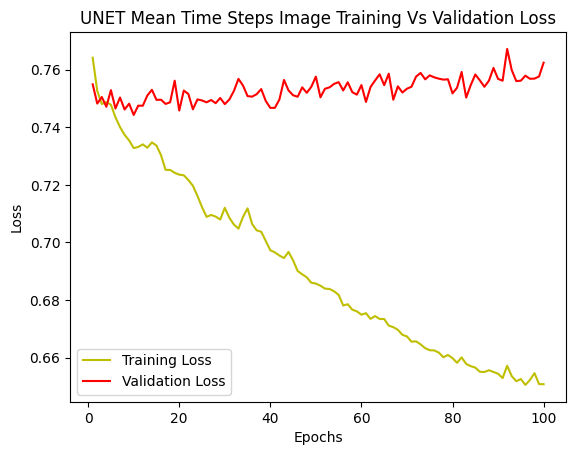

In [ ]:
# Visualize Results

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("UNET Mean Time Steps Image Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

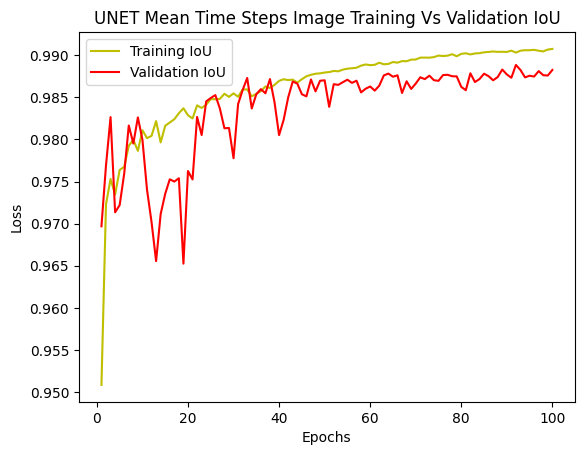

In [ ]:
jaccard_coef = history_2.history['jaccard_coef']
val_jaccard_coef = history_2.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("UNET Mean Time Steps Image Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

display(y_pred.shape, y_test.shape, y_pred_argmax.shape, y_test_argmax.shape)
print("")

test_img_2 = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
predicted_img_2 = y_pred_argmax[test_img_number]

display(test_img_2.shape, ground_truth.shape, predicted_img_2.shape)
print("")

7/7 [==============================] - 1s 78ms/step


(200, 256, 256, 2)

(200, 256, 256, 2)

(200, 256, 256)

(200, 256, 256)

(256, 256, 3)

(256, 256)

(256, 256)

In [ ]:
# Get Mean IOU for Experiment
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
mean_iou_2 = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou_2)

Mean IoU = 0.5146802


Text(0.5, 1.0, 'Ground Truth ID: 143')

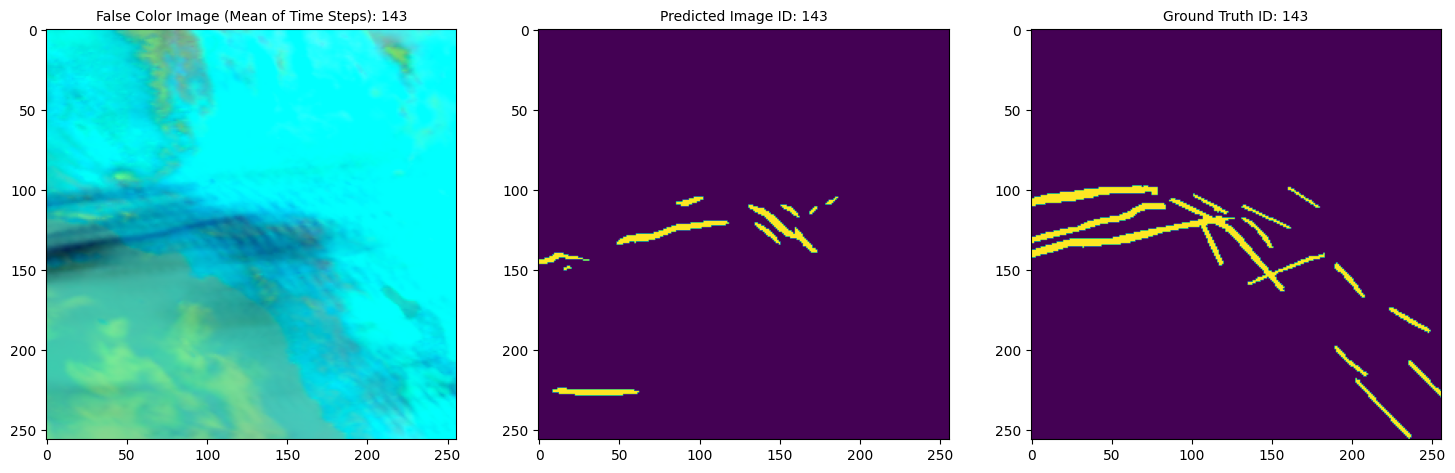

In [ ]:
# Visualize Predictions

plt.figure(figsize=(18,6))

ax = plt.subplot(1, 3, 1)
ax.imshow(test_img_2)
ax.set_title('False Color Image (Mean of Time Steps): '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 2)
ax.imshow(predicted_img_2)
ax.set_title('Predicted Image ID: '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 3)
ax.imshow(ground_truth)
ax.set_title('Ground Truth ID: '+str(test_img_number), fontsize=10)

In [ ]:
filepath = 'drive/My Drive/Data_SCI_W210_Capstone/Contrails/Model_Saved/model_2_focal_loss_5_blended.h5'
model.save(filepath)

In [ ]:
weights = [0.5,0.5] # hyper parameter
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (10 * focal_loss)

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
loaded_model = load_model(filepath,custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef})

In [ ]:
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# Experiment 3: Weighted Time Step Image Feature. Used weightings for each of the 8 time steps


In [ ]:
# Training dataset
master_training_dataset = image_weighted_dataset
print("training dataset shape: ", master_training_dataset.shape)

from sklearn.model_selection import train_test_split

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.20, random_state=100) # change later to 0.20

# inspect shapes of train and test
print("X Train Shape: ", X_train.shape)
print("X Test Shape: ", X_test.shape)
print("y train shape: ", y_train.shape)
print("y test shape: ", y_test.shape)

training dataset shape:  (1000, 256, 256, 3)
X Train Shape:  (800, 256, 256, 3)
X Test Shape:  (200, 256, 256, 3)
y train shape:  (800, 256, 256, 2)
y test shape:  (200, 256, 256, 2)


In [ ]:
history_3 = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          epochs=NUM_EPOCHS,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
25/25 [==============================] - 10s 396ms/step - loss: 0.6761 - accuracy: 0.9942 - jaccard_coef: 0.9879 - val_loss: 0.7227 - val_accuracy: 0.9922 - val_jaccard_coef: 0.9841
Epoch 2/100
25/25 [==============================] - 10s 382ms/step - loss: 0.6687 - accuracy: 0.9947 - jaccard_coef: 0.9889 - val_loss: 0.7311 - val_accuracy: 0.9940 - val_jaccard_coef: 0.9886
Epoch 3/100
25/25 [==============================] - 10s 388ms/step - loss: 0.6584 - accuracy: 0.9950 - jaccard_coef: 0.9895 - val_loss: 0.7264 - val_accuracy: 0.9939 - val_jaccard_coef: 0.9884
Epoch 4/100
25/25 [==============================] - 10s 389ms/step - loss: 0.6536 - accuracy: 0.9952 - jaccard_coef: 0.9899 - val_loss: 0.7160 - val_accuracy: 0.9930 - val_jaccard_coef: 0.9864
Epoch 5/100
25/25 [==============================] - 10s 385ms/step - loss: 0.6522 - accuracy: 0.9951 - jaccard_coef: 0.9898 - val_loss: 0.7280 - val_accuracy: 0.9941 - val_jaccard_coef: 0.9889
Epoch 6/100
25/25 [===========

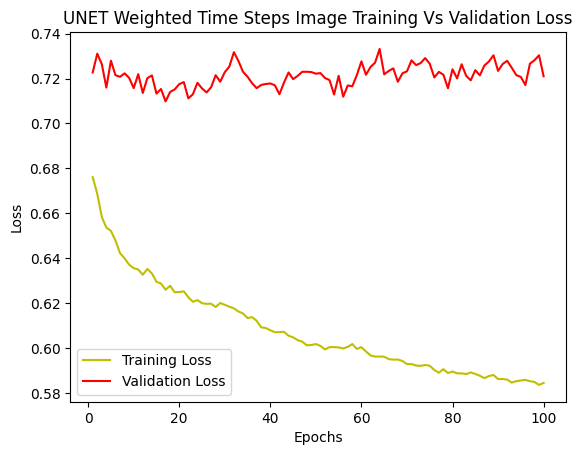

In [ ]:
# Visualize Results

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("UNET Weighted Time Steps Image Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

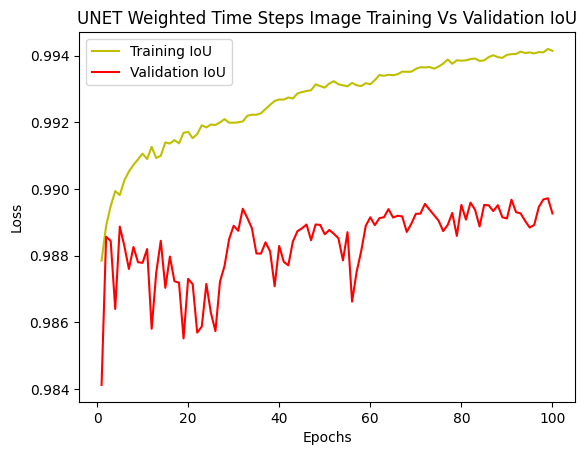

In [ ]:
jaccard_coef = history_3.history['jaccard_coef']
val_jaccard_coef = history_3.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("UNET Weighted Time Steps Image Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

display(y_pred.shape, y_test.shape, y_pred_argmax.shape, y_test_argmax.shape)
print("")

test_img_3 = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
predicted_img_3 = y_pred_argmax[test_img_number]

display(test_img_3.shape, ground_truth.shape, predicted_img_3.shape)
print("")

7/7 [==============================] - 0s 67ms/step


(200, 256, 256, 2)

(200, 256, 256, 2)

(200, 256, 256)

(200, 256, 256)

(256, 256, 3)

(256, 256)

(256, 256)

In [ ]:
# Get Mean IOU for Experiment
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
mean_iou_3 = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou_3)



Mean IoU = 0.558747


Text(0.5, 1.0, 'Ground Truth ID: 143')

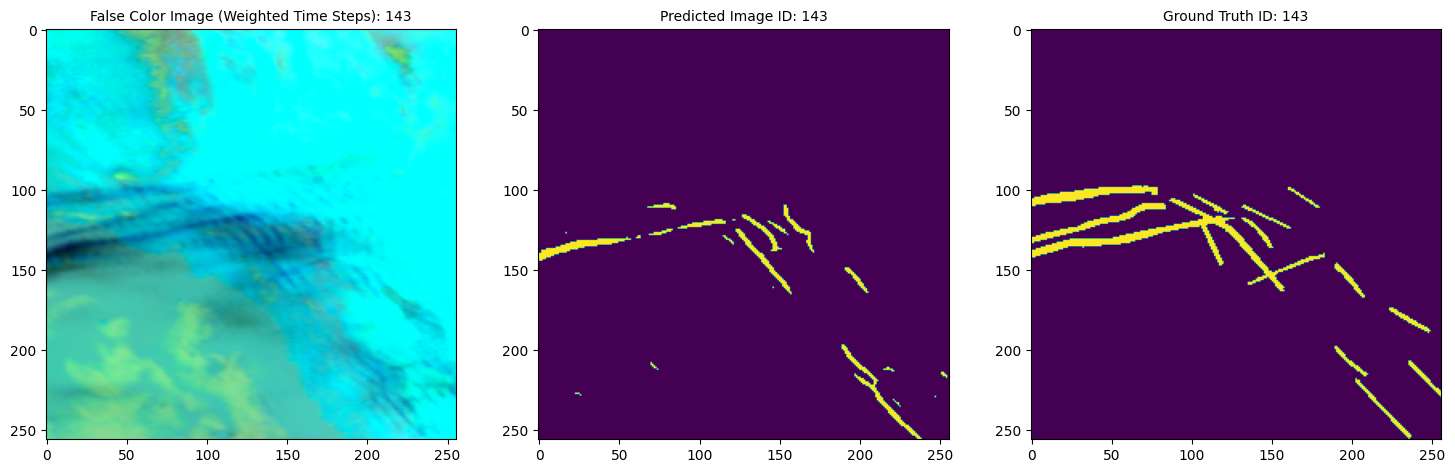

In [ ]:
# Visualize Predictions

plt.figure(figsize=(18,6))

ax = plt.subplot(1, 3, 1)
ax.imshow(test_img_3)
ax.set_title('False Color Image (Weighted Time Steps): '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 2)
ax.imshow(predicted_img_3)
ax.set_title('Predicted Image ID: '+str(test_img_number), fontsize=10)

ax = plt.subplot(1, 3, 3)
ax.imshow(ground_truth)
ax.set_title('Ground Truth ID: '+str(test_img_number), fontsize=10)

In [ ]:
filepath = 'drive/My Drive/Data_SCI_W210_Capstone/Contrails/Model_Saved/model_2_focal_loss_5_weighted.h5'
model.save(filepath)

In [ ]:
loaded_model = load_model(filepath,custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef})

In [ ]:
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# Summary Visualization of Three Experiments

Text(0.5, 1.0, 'Prediction Mean IOU: 0.56')

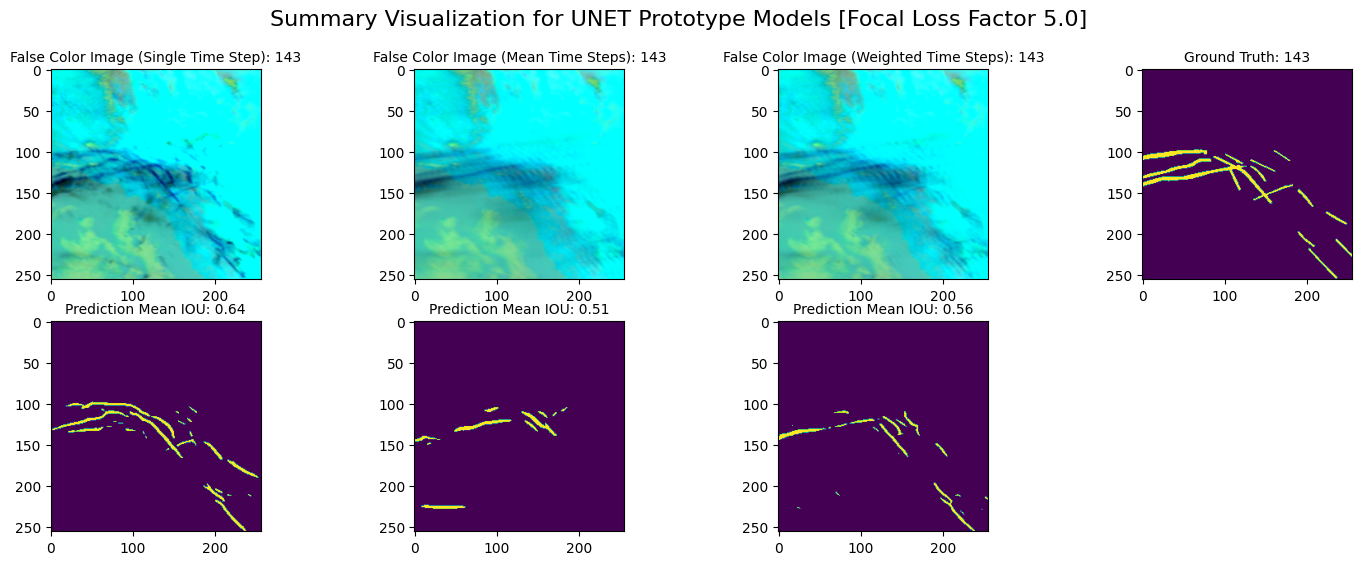

In [ ]:
# Visualize Predictions

plt.figure(figsize=(18,6))

plt.suptitle(f"Summary Visualization for UNET Prototype Models [Focal Loss Factor {TOTAL_LOSS_FACTOR:.1f}]", fontsize=16)

ax = plt.subplot(2, 4, 1)
ax.imshow(test_img_1)
ax.set_title('False Color Image (Single Time Step): '+str(test_img_number), fontsize=10)

ax = plt.subplot(2, 4, 2)
ax.imshow(test_img_2)
ax.set_title('False Color Image (Mean Time Steps): '+str(test_img_number), fontsize=10)

ax = plt.subplot(2, 4, 3)
ax.imshow(test_img_3)
ax.set_title('False Color Image (Weighted Time Steps): '+str(test_img_number), fontsize=10)

ax = plt.subplot(2, 4, 4)
ax.imshow(ground_truth)
ax.set_title('Ground Truth: '+str(test_img_number), fontsize=10)

ax = plt.subplot(2, 4, 5)
ax.imshow(predicted_img_1)
# ax.set_title('Prediction (Single Time Step)', fontsize=10)
ax.set_title( f"Prediction Mean IOU: {mean_iou_1:.2f}", fontsize="10")


ax = plt.subplot(2, 4, 6)
ax.imshow(predicted_img_2)
ax.set_title( f"Prediction Mean IOU: {mean_iou_2:.2f}", fontsize="10")

ax = plt.subplot(2, 4, 7)
ax.imshow(predicted_img_3)
ax.set_title( f"Prediction Mean IOU: {mean_iou_3:.2f}", fontsize="10")